In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad

In [3]:
import utils
from model import Model

In [4]:
data = utils.read_data()

In [5]:
train_data = data['seen']['signal'][:, 0][::2]
train_bvals = data['seen']['bvals'][::2]
train_bvecs = data['seen']['bvecs'][::2]
train_delta = data['seen']['delta'][::2]
train_Delta = data['seen']['Delta'][::2]
train_te = data['seen']['TE'][::2]
train_g = data['seen']['g'][::2]

test_data = data['seen']['signal'][:, 0][1::2]
test_bvals = data['seen']['bvals'][1::2]
test_bvecs = data['seen']['bvecs'][1::2]
test_delta = data['seen']['delta'][1::2]
test_Delta = data['seen']['Delta'][1::2]
test_te = data['seen']['TE'][1::2]
test_g = data['seen']['g'][1::2]


In [6]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)
test_gtab = grad.gradient_table(test_bvals, test_bvecs, big_delta=test_Delta, small_delta=test_delta)

In [7]:
train_s0 = train_data[train_gtab.b0s_mask]

In [8]:
p = np.polyfit(train_te[train_gtab.b0s_mask], np.log(train_data[train_gtab.b0s_mask]), 3)

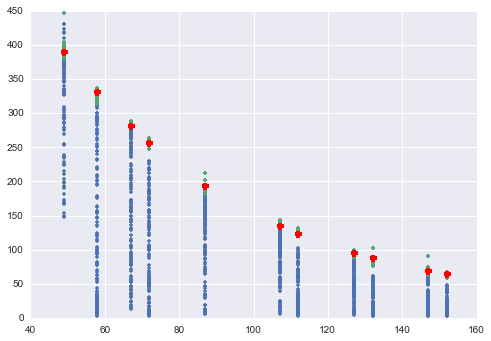

In [9]:
plt.plot(train_te, train_data, '.')
plt.plot(train_te[train_gtab.b0s_mask], train_data[train_gtab.b0s_mask], '.')
pred_lin = np.polyval(p, train_te)
plt.plot(train_te, np.exp(pred_lin), 'ro')

In [10]:
train_data_no_te = np.zeros_like(train_data)

In [11]:
for ii in range(train_data_no_te.shape[0]):
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    te_est = np.exp(np.polyval(p, this_te))
    train_data_no_te[ii] = train_data[ii]/te_est
    

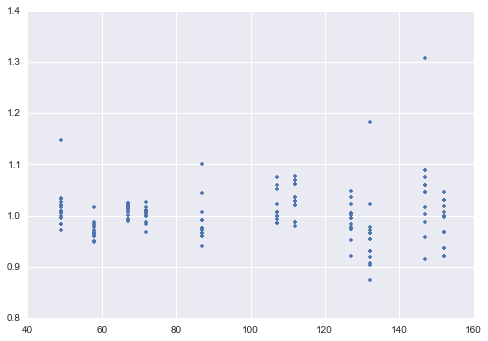

In [12]:
plt.plot(train_te[train_gtab.b0s_mask], train_data_no_te[train_gtab.b0s_mask], '.')

In [45]:
#model = sfm.SparseFascicleModel(train_gtab, isotropic=sfm.ExponentialIsotropicModel)
#model = dti.TensorModel(train_gtab)
model = Model(train_gtab, isotropic=sfm.ExponentialIsotropicModel, alpha=0.00001)

In [46]:
model.design_matrix.shape

(1485, 1086)

In [47]:
fit = model.fit(train_data_no_te)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [48]:
predict = fit.predict(test_gtab)

In [49]:
predict_with_te = np.zeros_like(predict)

In [50]:
for ii in range(predict_with_te.shape[0]):
    #this_te = train_te[ii]
    #te_idx = (train_te==this_te)
    #te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    #predict_with_te[ii] = predict[ii] * te_s0
    
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_est = np.exp(np.polyval(p, this_te))
    predict_with_te[ii] = predict[ii] * te_est

In [51]:
np.unique(train_Delta)

array([   0.,   17.,   19.,   20.,   21.,   23.,   37.,   38.,   39.,
         40.,   44.,   56.,   63.,   66.,   76.,   79.,   80.,   81.,
         82.,   87.,   95.,  100.,  102.,  109.,  113.,  114.,  119.,
        120.,  121.,  130.])

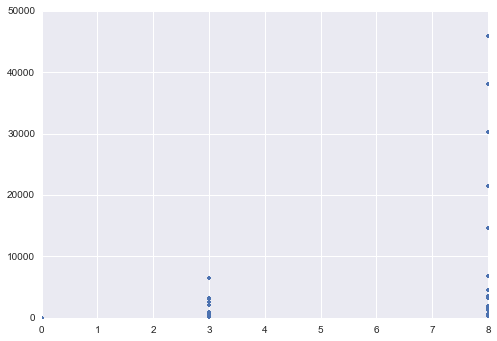

In [52]:
plt.plot(train_delta, train_gtab.bvals, '.')

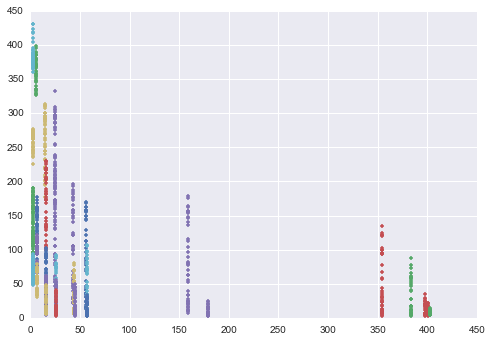

In [53]:
fig, ax = plt.subplots(1)
for this_Delta in np.unique(train_Delta):
    idx = train_Delta==this_Delta
    ax.plot(train_gtab.bvals[idx]/this_Delta, train_data[idx], '.', label=this_Delta)

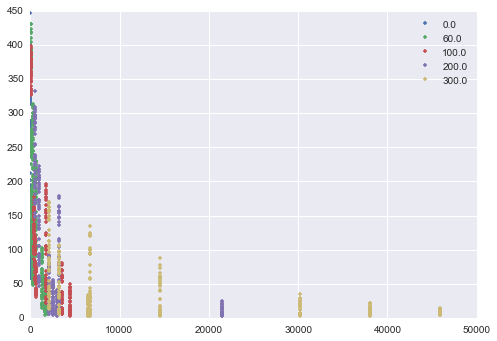

In [54]:
fig, ax = plt.subplots(1)
for this_g in np.unique(train_g):
    idx = train_g==this_g
    ax.plot(train_gtab.bvals[idx], train_data[idx], '.', label=this_g)
plt.legend()

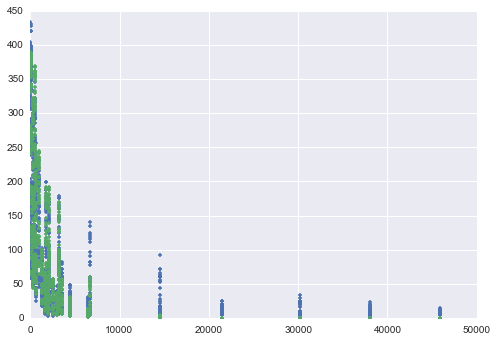

In [55]:
plt.plot(test_gtab.bvals, test_data, '.')
plt.plot(test_gtab.bvals, predict_with_te, '.')

In [56]:
def LSE(prediction, signal, sigma=8):
    return np.mean(((prediction - np.sqrt(signal**2 + sigma**2))**2)/(sigma**2))

In [57]:
LSE(predict_with_te, test_data)

5.9251652891697697

In [58]:
LSE(np.ones_like(train_data) * np.mean(train_data), train_data)

179.96553385160149

In [59]:
np.unique(test_Delta).shape

(30,)

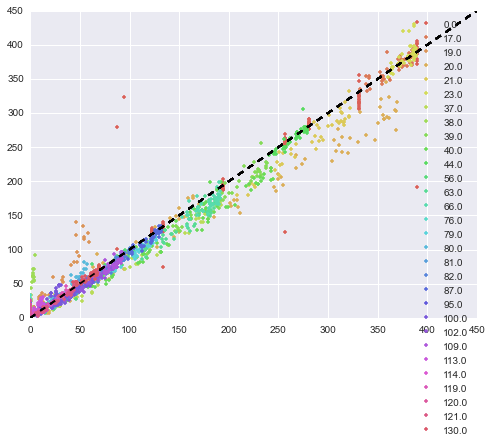

In [60]:
with sns.color_palette("hls", 30):
    fig, ax = plt.subplots(1)
    for this_Delta in np.unique(test_Delta):
        idx = test_Delta==this_Delta
        ax.plot(predict_with_te[idx], test_data[idx], '.', label=this_Delta)
        plt.plot([0, 450], [0, 450], 'k--')
    plt.legend()